In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

(2) Hydrogen VQE Example
========================

In [3]:
geo_file = "h2.xyz"

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Number of qubits = ", qubits)

Number of qubits =  4


For our ansatz, we use the circuit from the [VQE
tutorial](https://pennylane.ai/qml/demos/tutorial_vqe.html) but expand
out the arbitrary single-qubit rotations to elementary gates (RZ-RY-RZ).


In [4]:
dev = qml.device("lightning.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    # qml.BasisState(hf_state, wires=wires)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

Note that the qubit register has been initialized to $|1100\rangle$,
which encodes for the Hartree-Fock state of the hydrogen molecule
described in the minimal basis. Again, we define the cost function to be
the following QNode that measures `expval(H)`:


In [5]:
exact_value = -1.136189454088

We now set up our optimizations runs.


In [6]:
@qml.qnode(dev)
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

In [7]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-04

As was done with our previous VQE example, we run the standard gradient
descent optimizer.


In [8]:
opt = qml.GradientDescentOptimizer(step_size)

params = init_params

gd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.09424333 Ha
Iteration = 20,  Energy = -0.55156841 Ha
Iteration = 40,  Energy = -1.12731586 Ha

Final convergence parameter = 0.00009337 Ha
Number of iterations =  51
Final value of the ground-state energy = -1.13551998 Ha
Accuracy with respect to the FCI energy: 0.00066947 Ha (0.42009482 kcal/mol)

Final circuit parameters = 
 [3.44829694 6.28271026 3.78727399 3.42360201 0.03410232 4.0582724
 2.74944154 6.07646918 6.12121959 2.40923412 6.27933596 3.32314479]


#### Unsing Adam optimizer

In [9]:
opt = qml.AdamOptimizer(step_size)

params = init_params

adam_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    adam_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.30707269 Ha
Iteration = 20,  Energy = -1.09168372 Ha
Iteration = 40,  Energy = -1.12896005 Ha

Final convergence parameter = 0.00006329 Ha
Number of iterations =  48
Final value of the ground-state energy = -1.13136704 Ha
Accuracy with respect to the FCI energy: 0.00482242 Ha (3.02608182 kcal/mol)

Final circuit parameters = 
 [ 3.44829695  6.19914712  3.78727401  3.42360202 -0.03559182  4.05827242
  2.74944152  6.15682797  6.06069332  2.40923412  6.28232467  3.32314478]


Next, we run the optimizer employing quantum natural gradients. We also
need to make the Hamiltonian coefficients non-differentiable by setting
`requires_grad=False`.


In [10]:
hamiltonian = qml.Hamiltonian(np.array(hamiltonian.coeffs, requires_grad=False), hamiltonian.ops)

opt = qml.QNGOptimizer(step_size, lam=0.001, approx="block-diag")

params = init_params
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 4 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.32164519 Ha
Iteration = 4,  Energy = -0.46875033 Ha
Iteration = 8,  Energy = -0.85091050 Ha
Iteration = 12,  Energy = -1.13575339 Ha

Final convergence parameter = 0.00005376 Ha
Number of iterations =  14
Final value of the ground-state energy = -1.13618002 Ha
Accuracy with respect to the FCI energy: 0.00000944 Ha (0.00592189 kcal/mol)

Final circuit parameters = 
 [3.44829694 6.28318142 3.78727399 3.42360201 0.00749429 4.0582724
 2.74944154 6.07262586 6.27874585 2.40923412 6.28315827 3.32314479]


### RICCO Experiments Starts Here!

In [11]:
############## Extracting Pauli observables from the Hamiltonian ##################

pauli_strings = [qml.grouping.pauli_word_to_string(P, wire_map=range(4)) for P in hamiltonian.ops]
N_A_pauli_word = [ob[1] + ob[3] for ob in pauli_strings]
u_obs_list = sorted(set(N_A_pauli_word)) # set of observables for uncut qubits

main_pauli_strings = pauli_strings.copy()

grouped_paulis = []   # Grouping of all the observables in the Hamiltonian
grouped_coeffs = []   # Grouping of all the coefficients in the Hamiltonian

u_grouped_paulis = [] # Grouping of Subcircuit_u observables in the Hamiltonian
v_grouped_paulis = [] # Grouping of Subcircuit_v observables in the Hamiltonian

H_coeff = hamiltonian.coeffs     # Hamoltonian coefficients
H_coeff = [float(c) for c in H_coeff]

for test in sorted(u_obs_list):
    tmp_ob = []
    tmp_coeff = []
    tmp_coeffs = []
    tmp_u = []
    tmp_v = []
    for i, word in enumerate(pauli_strings):
        if word[1] + word[3] == test:       # group observables based on the obserabes of A0 and A1
            tmp_ob.append(word)
            tmp_u.append(word[1] + word[3]) # extract observables for qubits labelled A0 and A1
            tmp_v.append(word[0] + word[2]) # extract observables for qubits labelled C0 and B0
            tmp_coeffs.append(H_coeff[i])
            tmp_coeff.append(float(H_coeff[i]))
    for j, k in zip(tmp_ob, tmp_coeff):
        pauli_strings.remove(j)
        H_coeff.remove(k)
        
    grouped_paulis.append(tmp_ob)
    grouped_coeffs.append(tmp_coeffs)
    u_grouped_paulis.append(tmp_u)  
    v_grouped_paulis.append(tmp_v) 

In [12]:
##################### Defining Subcircuits ##################################


N_A_wires = 2
N_B_wires = 1
N_C_wires = 1


N_AB_wires = N_A_wires + N_B_wires            # subcircuit_AB total wires
N_BC_wires = N_B_wires + N_C_wires            # subcircuit_BC total wires
N_wires = N_A_wires + N_B_wires + N_C_wires   # total wires in circuit

# Generating labels for the differenct wires
A_wires = ["A" + str(x) for x in list(range(N_A_wires))]
B_wires = ["B" + str(x) for x in list(range(N_B_wires))]
C_wires = ["C" + str(x) for x in list(range(N_C_wires))]

# mapping the wires to their respective labels
A_wire_map = {x: idx for idx, x in enumerate(A_wires)}
B_wire_map = {x: idx for idx, x in enumerate(B_wires)}
C_wire_map = {x: idx for idx, x in enumerate(C_wires)}

# wire labels for the different subcircuits
AB_wires = [A_wires[0]] + B_wires + [A_wires[1]]             # subcircuit_AB wire labels
BC_wires = C_wires  + B_wires            # subcircuit_BC twire labels
all_wires = C_wires + AB_wires   # total wire labels

# wire mapping for the different subcircuits
AB_wires_map = {x: idx for idx, x in enumerate(AB_wires)}
BC_wires_map = {x: idx for idx, x in enumerate(BC_wires)}
all_wires_map = {x: idx for idx, x in enumerate(all_wires)}

# Generating and ordering Pauli group for N_B_wires
N_B_grouped = qml.grouping.partition_pauli_group(N_B_wires)
N_B_grouped_flat = [term for group in N_B_grouped for term in group]
N_B_order = qml.math.argsort(N_B_grouped_flat)
N_B_pauli_word = qml.math.array(N_B_grouped_flat)[N_B_order]
opt_pauli_string = [P for P in N_B_pauli_word if all( [c in set('IZ') for c in P])]

# Pauli I and Z and their respective eigenvectors and eigenvalues
I = ["0", "1"]                   # eigenvectors of I
I_sign = qml.math.array([1, 1])  # eigenvalues of I

Z = ["0", "1"]                   # eigenvectors of Z
Z_sign = qml.math.array([1, -1]) # eigenvalues of Z

meas_to_prep_state_dic = {"I":I, "Z":Z}           # Dictionary for eigenvectors
meas_to_prep_sign_dic = {"I":I_sign, "Z":Z_sign}  # Dictionary for eigenvalues

def observables_and_eigenvalues_u(obs):
    # Observable for the uncut qubits (A0 and A1) of subcircuit_u
    N_A_pauli_word = obs

    # Pauli strings for the subcircuit_u
    # sandwich qubit B0 between qubits A0 and A1
    AB_pauli_labels = [N_A_pauli_word[0] + word + N_A_pauli_word[1] for word in N_B_pauli_word]

    # convert the Pauli strings to Pauli observables mappped to the respective wires
    AB_paulis = [qml.grouping.string_to_pauli_word(P, wire_map=AB_wires_map) 
                  for P in AB_pauli_labels]

    # Paulis with only Z or I
    opt_paulis = [qml.grouping.string_to_pauli_word(P, wire_map=AB_wires_map) 
                  for P, B in zip(AB_pauli_labels, N_B_pauli_word) if 
                  all( [c in set('IZ') for c in B]
    )]

    eig_list = []
    for string in opt_pauli_string:
        eig = 0
        for indx, ob in enumerate(string):
            if indx==0:
                eig = meas_to_prep_sign_dic[ob]
            else:
                eig = qml.math.kron(eig, meas_to_prep_sign_dic[ob])
        eig_list.append(list(eig))

    eigvals = np.array(eig_list)
    
    return N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals


In [13]:
def main_and_v_observables(obs):
    """
    return the observables for subcircuit_v and the observable for the entire circuit
    """
    # Pauli strings for qubits B0 and C0 of subcircuits_v
    N_BC_pauli_word = obs[0] + obs[2]
    BC_pauli_labels = [N_BC_pauli_word]

    BC_paulis = [qml.grouping.string_to_pauli_word(P, wire_map=BC_wires_map) 
                      for P in BC_pauli_labels]

    op = qml.grouping.string_to_pauli_word(obs, wire_map=all_wires_map)
    return BC_paulis, BC_pauli_labels, op

In [14]:
# Define ricco Parameters
ricco_params = np.random.uniform(-np.pi, np.pi, size=4**N_B_wires-1)

# parameters for vqe gates
# vqe_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
vqe_params = init_params

tensor(0.01929463, requires_grad=True)

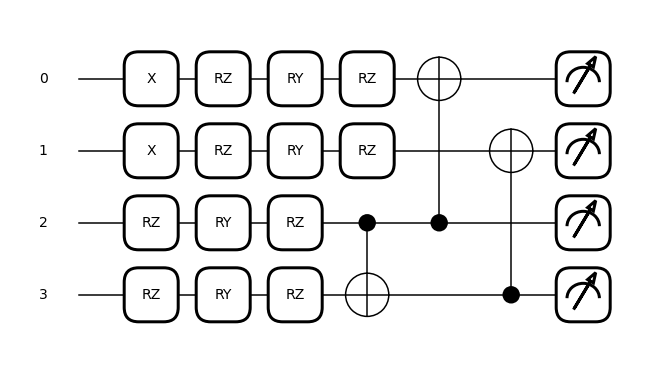

In [15]:
fig, _ = qml.draw_mpl(cost)(vqe_params)
cost(vqe_params)

In [16]:
dev = qml.device("lightning.qubit", wires=all_wires)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def modified_ansatz(vqe_params, wires=all_wires):
    # qml.BasisState(hf_state, wires=wires)
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    for i, j in enumerate(wires):
        qml.RZ(vqe_params[3 * i], wires=j)
        qml.RY(vqe_params[3 * i + 1], wires=j)
        qml.RZ(vqe_params[3 * i + 2], wires=j)
    qml.CNOT(wires=[wires[2], wires[3]])
    
    qml.WireCut(wires=wires[2])
    
    qml.CNOT(wires=[wires[2], wires[0]])
    qml.CNOT(wires=[wires[3], wires[1]])

In [17]:
@qml.qnode(dev)
def modified_cost(_vqe_params):
    modified_ansatz(_vqe_params, wires=all_wires)
    return qml.expval(modified_hamiltonian)

In [18]:
wires_map = {i:j for i,j in zip(range(N_wires), all_wires)}

wires_AB_map = {key: value for key,value in wires_map.items() if ('A' in value or 'B' in value)}

wires_BC_map = {key: value for key,value in wires_map.items() if ('C' in value)}

In [19]:
import copy
def map_wires(H, wires_map):
    """Map the wires of an Observable according to a wires map.
    
    Args:
        H (Hamiltonian or Tensor or Observable): Hamiltonian to remap the wires of.
        wires_map (dict): Wires map with `(origin, destination)` pairs as key-value pairs.
    
    Returns:
        Hamiltonian or Tensor or Observable: A copy of the original Hamiltonian with remapped wires.
    """
    if isinstance(H, qml.Hamiltonian):
        new_ops = [map_wires(op, wires_map) for op in H.ops]
        new_H = qml.Hamiltonian(H.coeffs, new_ops)
    elif isinstance(H, qml.operation.Tensor):
        new_obs = [map_wires(ob, wires_map) for ob in H.obs]
        new_H = qml.operation.Tensor(*new_obs)
    elif isinstance(H, qml.operation.Observable):
        new_H = copy.copy(H)
        new_H._wires = new_H.wires.map(wires_map)
        
    return new_H

modified_hamiltonian = map_wires(hamiltonian, wires_map)

tensor(0.01929463, requires_grad=True)

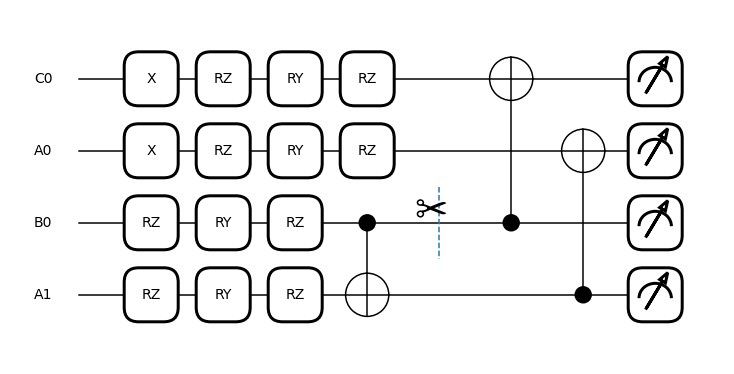

In [20]:
fig, _ = qml.draw_mpl(modified_cost)(vqe_params)
modified_cost(vqe_params)

In [21]:
# intentionally did this for variables  BC_paulis, op
bc_and_all_obs = []
for group in grouped_paulis:
    tmp_group = []
    for obs in group:
        BC_paulis, BC_pauli_labels, op = main_and_v_observables(obs)
        tmp_group.append([BC_paulis, BC_pauli_labels, op])
    bc_and_all_obs.append(tmp_group)

In [22]:
# intentionally did this for variables  AB_paulis, opt_paulis
opt_list = []
for obs in u_obs_list:
    N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals = \
                                                        observables_and_eigenvalues_u(obs)
    opt_list.append([N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals])

In [23]:
N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals = opt_list[0]
BC_paulis, BC_pauli_labels, op = bc_and_all_obs[0][0]

In [24]:
def vqe_template_AB(vqe_params, wires=AB_wires):
    qml.PauliX(wires=wires[0])
    for i, j in wires_AB_map.items():
        qml.RZ(vqe_params[3 * i], wires=j)
        qml.RY(vqe_params[3 * i + 1], wires=j)
        qml.RZ(vqe_params[3 * i + 2], wires=j)
    qml.CNOT(wires=[wires[1], wires[2]])
    
    qml.CNOT(wires=[wires[2], wires[0]])

In [25]:
def vqe_template_BC(vqe_params, wires=BC_wires):
    qml.PauliX(wires=wires[0])
    for i, j in wires_BC_map.items():
        qml.RZ(vqe_params[3 * i], wires=j)
        qml.RY(vqe_params[3 * i + 1], wires=j)
        qml.RZ(vqe_params[3 * i + 2], wires=j)
    
    qml.CNOT(wires=[wires[1], wires[0]])

In [26]:
# Unitary operator to be used at cut location for one qubit cut
def one_qubit_unitary(ricco_params, wires):
    """Ansatz for a general two-qubit unitary V."""
    qml.Rot(*ricco_params, wires=B_wires)

# Conjugate of Unitary operator to be used at cut location for one qubit cut
def one_qubit_unitary_dagger(ricco_params, wires):
    """Ansatz for a general two-qubit unitary V."""
    qml.adjoint(one_qubit_unitary)(ricco_params, wires)

In [27]:
def quantum_function_for_AB(vqe_params, ricco_params):
    vqe_template_AB(vqe_params) # Using optimal_params for template cct.
    one_qubit_unitary(ricco_params, wires=B_wires)
    
def quantum_function_for_BC(vqe_params, ricco_params):
    one_qubit_unitary_dagger(ricco_params, wires=B_wires)
    vqe_template_BC(vqe_params) # Using optimal_params for template cct.

In [28]:
# Defining the first half of the cut circuit - Subcircuit_AB
dev = qml.device("lightning.qubit", wires=AB_wires)
    
@qml.qnode(dev)
def subcircuit_for_AB(vqe_params, ricco_params, opt_paulis):
    quantum_function_for_AB(vqe_params, ricco_params)
    return [qml.expval(P) for P in opt_paulis]

@qml.qnode(dev)
def subcircuit_for_test(vqe_params, ricco_params, AB_paulis):
    quantum_function_for_AB(vqe_params, ricco_params)
    return [qml.expval(P) for P in AB_paulis]

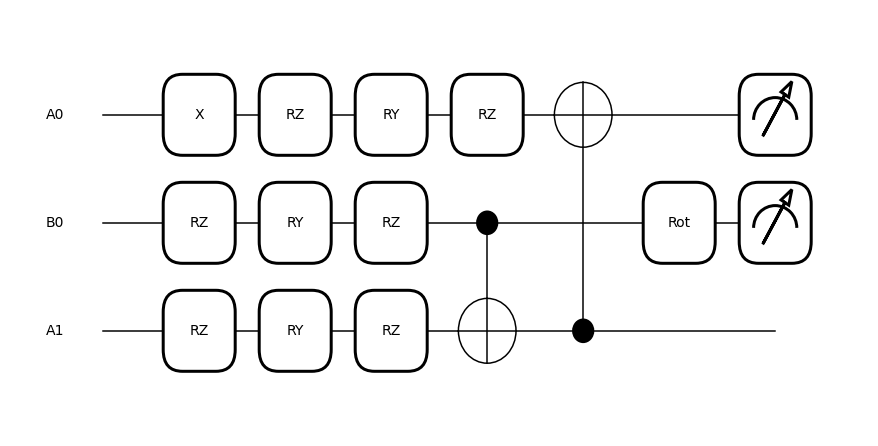

In [29]:
fig, _ = qml.draw_mpl(subcircuit_for_AB)(vqe_params, ricco_params, opt_paulis)
fig.set_size_inches(12,6)

In [30]:
# Defining the second half of the cut circuit - Subcircuit_BC
dev = qml.device("lightning.qubit", wires=BC_wires)
    
@qml.qnode(dev)
def subcircuit_for_BC(vqe_params, ricco_params, BC_paulis):
    quantum_function_for_BC(vqe_params, ricco_params)
    return [qml.expval(P) for P in BC_paulis]

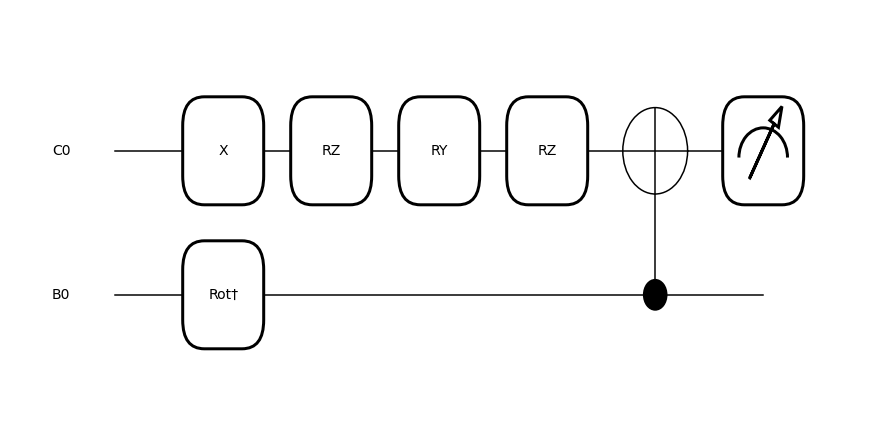

In [31]:
fig, _ = qml.draw_mpl(subcircuit_for_BC)(vqe_params, ricco_params, BC_paulis)
fig.set_size_inches(12,6)

### Sanity Checks

tensor(0.01929463, requires_grad=True)

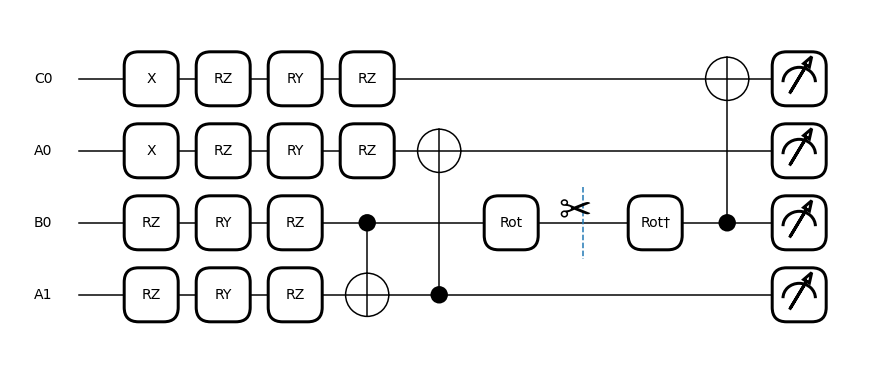

In [32]:
# Original uncut circuit with parameterized unitaries at cut locations
dev = qml.device("lightning.qubit", wires=all_wires)
@qml.qnode(dev)
def combined_circuit(params):
    quantum_function_for_AB(vqe_params, ricco_params)
    qml.WireCut(wires=B_wires)
    quantum_function_for_BC(vqe_params, ricco_params)
    return qml.expval(modified_hamiltonian)

fig, ax = qml.draw_mpl(combined_circuit)(params)
combined_expval = combined_circuit(params)
combined_expval

tensor(0.01929463, requires_grad=True)

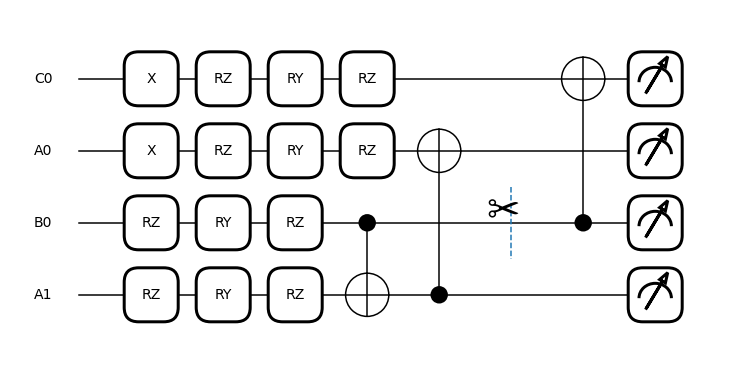

In [33]:
# Original uncut circuit with parameterized unitaries at cut locations
dev = qml.device("lightning.qubit", wires=all_wires)
@qml.qnode(dev)
def uncut_circuit():
    vqe_template_AB(vqe_params)
    qml.WireCut(wires=B_wires)
    vqe_template_BC(vqe_params)
    return qml.expval(modified_hamiltonian)

fig, ax = qml.draw_mpl(uncut_circuit)()
uncut_expval = uncut_circuit()
uncut_expval

In [34]:
modified_cost(vqe_params)

tensor(0.01929463, requires_grad=True)

In [35]:
import numpy as np
from qiskit.quantum_info import Pauli, Statevector

def construct_M_x(pauli_operators):
    """
    Constructs the M_x matrix with expectation values of Pauli operators 
    with respect to computational basis states.

    Parameters:
    - pauli_operators: List of Pauli strings (e.g., ['ZI', 'ZZ']).
    - num_cut_qubits: Number of cut qubits in the system. This is usually the last
                      k-qubits from the end of the pauli_operators

    Returns:
    - M_x: A numpy matrix of shape (len(pauli_operators), 2^num_qubits).
    """

    # Number of basis states
    num_qubits = len(pauli_operators[0])
    num_basis_states = 2 ** num_qubits

    # Initialize the matrix M_x
    M_x = np.zeros((num_basis_states, len(pauli_operators)))

    # Compute expectation values for Pauli operator P_i
    for col, pauli_str in enumerate(pauli_operators):

        # Loop through all computational basis states
        for row, state_int in enumerate(range(num_basis_states)):
            # Generate the computational basis state |x⟩ as a Statevector
            basis_state = Statevector.from_label(f"{state_int:0{num_qubits}b}")
            pauli = Pauli(pauli_str)
            expectation_value = basis_state.expectation_value(pauli)
            M_x[row, col] = np.real(expectation_value)  # Store the real part
        

    return M_x

# # Example usage:
# pauli_operators = ['ZZ', 'ZI']  # List of Pauli strings for 1 qubit
# # num_qubits = 2  # Number of qubits in the system
# M_x = construct_M_x(pauli_operators)

# print("Constructed M_x matrix:")
# print(M_x)


In [36]:
AB_pauli_labels

['III', 'IXI', 'IYI', 'IZI']

In [37]:
def ricco_optimizer(init_ricco_params, ricco_params, opt_list, vqe_params):
    """
    This function performs optimization on the RICCO parameters alone.
    Input---> opt_list: a list containing the observables in the Hamiltonian for 
                        subcircuit_AB to be optimized and their eigenvalues. Gotten from
                        the results of this function `observables_and_eigenvalues_u(obs)`
    Output--> opt_params_list: list containing the optimized values of the RICCO parameters
                               for each observable in the Hamiltonian
              opt_cost_list: a list of the cost during optimization for each observable in 
                             the Hamiltonian
              opt_exec_list: list of the number of executions during the optimization of each
                             observable of the Hamiltonian
              outputs_list: a list of the optimized expectation values of observables for each
                            Hamiltonian term (or observable)
    """
    

    opt_params_list = []
    opt_cost_list = []
    # opt_exec_list = []

    labels_and_eignenvalues = []

    for indx, opt in enumerate(opt_list):
        # chose from init_ricco_params only after the first round of optimization
        if init_ricco_params:
            ricco_params = init_ricco_params[indx]
        else:
            ricco_params = ricco_params

        N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals = opt

        labels_and_eignenvalues.append([N_A_pauli_word, AB_paulis, AB_pauli_labels, eigvals])

#         def cost_function(ricco_params):
            
#             expvals = subcircuit_for_AB(vqe_params, ricco_params, opt_paulis)
                
#             F = (1 - ((1/2**N_B_wires)**(2**N_B_wires))*np.sum(expvals 
#                                                                * eigvals, axis=1))**2
#             return np.prod(F)
        
        def cost_function(ricco_params):
            expvals = subcircuit_for_AB(vqe_params, ricco_params, opt_paulis)
            F = -np.abs(expvals)
            return np.sum(F)
        
        # def cost_function(ricco_params):
        #     expvals = subcircuit_for_AB(vqe_params, ricco_params, opt_paulis)
        #     # F = np.abs(expvals)
        #     F = expvals * eigvals
        #     F = np.abs(F)
        #     return -np.sum(F)
        
        # def cost_function(ricco_params):
        #     expvals = subcircuit_for_AB(vqe_params, ricco_params, opt_paulis)
        #     F = np.abs(expvals)
        #     return (1 -(1/(2**N_B_wires-1))*np.sum(F))**2

        
        N_steps = 0
        conv_tol = 1e-6
        # step_size = step_size
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        cost = []
        prev_cost = 100
        while tol > conv_tol:
            cost.append(prev_cost)
            ricco_params, new_cost = ricco_opt.step_and_cost(cost_function, ricco_params)

            # Calculate difference between new and old energies
            tol = np.abs((prev_cost - new_cost))
            prev_cost = new_cost
            N_steps += 1

        opt_params_list.append(ricco_params)
        opt_cost_list.append(cost)
        # opt_exec_list.append(AB_tracker.totals["executions"])
        # outputs_list.append(subcircuit_for_test(vqe_params, ricco_params, AB_paulis))
        
    return opt_params_list, opt_cost_list

In [38]:
# Defining the first half of the cut circuit - Subcircuit_AB
dev = qml.device("lightning.qubit", wires=AB_wires)
    
@qml.qnode(dev)
def subcircuit_for_AB_reconst(vqe_params, ricco_params, opt_paulis):
    quantum_function_for_AB(vqe_params, ricco_params)
    return [qml.expval(P) for P in opt_paulis]

In [39]:
# Subcircuit_BC redefined to account for initializations
dev = qml.device("lightning.qubit", wires=BC_wires)

@qml.qnode(dev)
def subcircuit_for_BC_reconst(init, vqe_params, ricco_params, BC_paulis):
    for i, state in enumerate(init):
        if state == "1":
            qml.PauliX(wires=B_wires[i])

    quantum_function_for_BC(vqe_params, ricco_params)
    return [qml.expval(P) for P in BC_paulis]

In [40]:
def compute_expval(prepare_result, measure_result, opt_pauli_string, AB_pauli_labels, N_B_pauli_word):
    expectations = []
    for string in opt_pauli_string:
        for indx, ob in enumerate(string):
            if indx == 0:
                x_state = meas_to_prep_state_dic[ob]
                x_sign = meas_to_prep_sign_dic[ob]
            else:
                y_state = meas_to_prep_state_dic[ob]
                y_sign = meas_to_prep_sign_dic[ob]

                x_state = [m+n for m, n in list(product(x_state, y_state))]
                x_sign = qml.math.kron(x_sign, y_sign)

        p_word = [word for word, B in zip(AB_pauli_labels, N_B_pauli_word)
               if all( [c in set(string) for c in B])][0]
        meas_expval = measure_result[p_word]

        prep_values = []
        for state in x_state:
            prep_values.append(prepare_result[state])


        prep_expval = np.array(prep_values)

        combined_expval = meas_expval * prep_expval
        expectations.append(np.dot(combined_expval, x_sign))

    total_expval = 1/(2**N_B_wires) * np.sum(np.array(expectations))

    return total_expval

In [41]:
# ###### Recontruction of Original Circuit's Expectation Value

def ricco_reconstruction(vqe_params, opt_params_list, opt_list, bc_and_all_obs, num_shots):
    """
    This function is used to reconstruct the expectation value of the Halmiltonian
    after the optimization of RICCO parameters.
    Input ---> opt_params_list: List of optimized RICCO parameters.
               bc_and_all_obs: List of all obersavables in the Hamiltonian that belong
                               to subcircuit_BC and the full observables that make up the 
                               Hamiltonian
               num_shots:  The number of shots need to execute each circuit
    Output --> ricco_expval: The expectation value of the reconstructed circuit using RICCO
    """
    expvals = []
    executions = []
    for indx, ricco_params in enumerate(opt_params_list): 
        N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals = opt_list[indx]
        
        # Measurement of Subcircuit_AB
        meas = subcircuit_for_AB_reconst(vqe_params, ricco_params, opt_paulis, shots=num_shots)
        # Dictionary for Subcircuit_AB expectation values
        meas_labels = [word for word, B in zip(AB_pauli_labels, N_B_pauli_word)
                       if all( [c in set('IZ') for c in B])]

        # measure_result = {key: value.item() for key, value in zip(meas_labels, meas)}
        measure_result = {key: value for key, value in zip(meas_labels, meas)}
        
        # Begin subcircuit_v
        for j, obs in enumerate(bc_and_all_obs[indx]):
            BC_paulis, BC_pauli_labels, op = obs
            
            coeffs = grouped_coeffs[indx][j]   # Get the coefficient associate with the observable

            # states combinations for observables I and Z for one and two qubits
            if N_B_wires == 1:
                states = Z
            else:
                states = [m+n for m, n in list(product(I, Z))]

            
            # Measurement of Subcircuit_BC with initializations
            prep_measurements = []
            for init in states:
                prep_meas = subcircuit_for_BC_reconst(init, vqe_params, ricco_params, BC_paulis)[0]
                prep_measurements.append(prep_meas)

            # Dictionary for Subcircuit_BC expectation values
            prep = np.array(prep_measurements)
            prep_labels = states
            prepare_result = {key: value for key, value in zip(prep_labels, prep)}
            
            value = compute_expval(prepare_result, measure_result, opt_pauli_string, 
                                   AB_pauli_labels, N_B_pauli_word)
            
            expvals.append(coeffs * value)
            
            

    ricco_expval = np.sum(np.array(expvals))
    
    return ricco_expval

In [42]:
def ricco_expectation(vqe_params, opt_list, num_shots):
    ricco_expval = ricco_reconstruction(vqe_params, opt_params_list, opt_list, 
                                        bc_and_all_obs, num_shots)
    return ricco_expval

In [43]:
init_ricco_params = []
opt_params_list, opt_cost_list = ricco_optimizer(init_ricco_params, ricco_params, opt_list, vqe_params)
ricco_reconstruction(vqe_params, opt_params_list, opt_list, bc_and_all_obs, num_shots=None)

0.020044264593815017

In [44]:
# ricco_reconstruction(vqe_params, opt_params_list, opt_list, bc_and_all_obs, num_shots=None)

In [45]:
modified_cost(vqe_params)

tensor(0.01929463, requires_grad=True)

In [46]:
def vqe_cost_function(vqe_params):    
    cost_expval = ricco_expectation(vqe_params, opt_list, num_shots=None)
    return cost_expval

vqe_opt = qml.AdamOptimizer(stepsize=step_size)

prev_energy = 0.1

# init_ricco_params = [ricco_params]*len(opt_list)
init_ricco_params = []

ricco_adam_param_history = [vqe_params]
ricco_adam_cost_history = [prev_energy]

with qml.Tracker(subcircuit_for_BC_reconst.device) as BC_tracker:
    with qml.Tracker(subcircuit_for_AB_reconst.device) as AB_reconstruction_tracker:
        with qml.Tracker(subcircuit_for_AB.device) as AB_optimization_tracker:
            for n in range(max_iterations):

                opt_params_list, opt_cost_list = ricco_optimizer(init_ricco_params, ricco_params, opt_list, vqe_params)

                # update ricco_params
                init_ricco_params = opt_params_list

                # Take step for vqe optimization
                vqe_params, energy = vqe_opt.step_and_cost(vqe_cost_function, vqe_params)

                ricco_adam_param_history.append(vqe_params)
                ricco_adam_cost_history.append(energy)


                # Calculate difference between new and old energies
                conv = np.abs(energy - prev_energy)

                prev_energy = energy


                if n % 20 == 0:
                    print(
                        "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
                        ":.8f} Ha".format(n, energy, conv)
                    )

                if conv <= conv_tol:
                    break

            print()
            print("Final value of the energy = {:.8f} Ha".format(energy))
            print("Number of iterations = ", n)

TypeError: unsupported format string passed to ArrayBox.__format__

### Qcut Starts Here!

In [ ]:
dev = qml.device("lightning.qubit", wires=qubits)
@qml.cut_circuit(auto_cutter=True)
@qml.qnode(dev)
def qcut_cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

In [ ]:
qcut_opt = qml.AdamOptimizer(stepsize=step_size)

qcut_params = init_params

qcut_adam_cost = []

prev_energy = 0.1

with qml.Tracker(qcut_cost.device) as qcut_tracker:
    for n in range(max_iterations):
        qcut_params, energy = qcut_opt.step_and_cost(qcut_cost, qcut_params)
        qcut_adam_cost.append(energy)
        
        conv = np.abs(energy - prev_energy)
        
        prev_energy = energy

        if n % 20 == 0:
            print(
                "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
                ":.8f} Ha".format(n, energy, conv)
            )


        if conv <= conv_tol:
            break


    print()
    print("Final convergence parameter = {:.8f} Ha".format(conv))
    print("Number of iterations = ", n)
    print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
    print(
        "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
            np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
        )
    )
    print()
    print("Final circuit parameters = \n", qcut_params)

In [ ]:
qcut_tracker.totals['executions']

In [ ]:
# AB_total_tracker.totals

In [ ]:
AB_optimization_tracker.totals['executions']

In [ ]:
BC_tracker.totals['executions']

In [ ]:
AB_reconstruction_tracker.totals['executions']

Visualizing the results
=======================

(a) comparing the number of steps it takes to reach our ground state estimate


In [ ]:
# Adjusting the data to handle varying lengths by padding with NaNs for alignment
from pandas import DataFrame
import numpy as np
import os

# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Finding the maximum length among the arrays
max_length = max(len(ricco_adam_cost_history), len(adam_cost), len(qcut_adam_cost))

# Padding shorter arrays with NaN values to match the maximum length
ricco_adam_cost_history_padded = np.pad(ricco_adam_cost_history, 
                                        (0, max_length - len(ricco_adam_cost_history)), 
                                        constant_values=np.nan)
adam_cost_padded = np.pad(adam_cost, 
                          (0, max_length - len(adam_cost)), 
                          constant_values=np.nan)
qcut_adam_cost_padded = np.pad(qcut_adam_cost, 
                               (0, max_length - len(qcut_adam_cost)), 
                               constant_values=np.nan)

# Create a DataFrame to store the aligned data
aligned_data = DataFrame({
    "RICCO_Adam_Cost_History": ricco_adam_cost_history_padded,
    "Adam_Cost": adam_cost_padded,
    "QCUT_Adam_Cost": qcut_adam_cost_padded
})

# Save the aligned data to a CSV file
aligned_data_path = "ricco_vqe_plots/ricco_vqe_cost_data.csv"
aligned_data.to_csv(aligned_data_path, index=False)

aligned_data_path


In [ ]:
# import os
# import matplotlib.pyplot as plt
# import numpy as np

# # Ensure the directory exists
# os.makedirs("plots_supremacy_cct", exist_ok=True)

# # Adjust the figure size and set DPI for higher quality output
# plt.figure(figsize=(8, 6), dpi=700)  # Adjusted size to suit typical LaTeX document width

# # Plot for QCUT with Adam
# plt.plot(qcut_adam_cost, label='QCUT with Adam', marker='o', color='red', linestyle='-', 
#          markersize=4, linewidth=3)
# # plt.plot(qcut_adam_cost, label='QCUT with Adam', color='red', linestyle='-', 
# #          markersize=4, linewidth=3)


# # Plot for RICCO with Adam
# plt.plot(ricco_adam_cost_history, label='RICCO with Adam', marker='^', color='green', 
#          linestyle='-', markersize=4, linewidth=3)
# # plt.plot(ricco_adam_cost_history, label='RICCO with Adam', color='green', linestyle='-', 
# #          markersize=4, linewidth=3)

# # Plot for Adam
# plt.plot(adam_cost, label='Adam', marker='x', color='orange', linestyle='-', 
# markersize=4, linewidth=3)
# # plt.plot(adam_cost, label='Adam', color='orange', linestyle='-', markersize=4, linewidth=3)

# # Adding titles and labels with increased font size for better readability
# plt.xlabel('Optimization Steps', fontsize=18, fontweight='bold')
# plt.ylabel('Cost Function Value', fontsize=18, fontweight='bold')
# plt.legend(prop={'size': 18, 'weight': 'bold'})

# plt.xticks(fontweight='bold', fontsize=18)
# plt.yticks(fontweight='bold', fontsize=18)

# # Save the plot to file
# fig_path = "ricco_vqe_plots/Cost_function_value.pdf"
# plt.savefig(fig_path)

# # Display the plot
# plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Adjust the figure size and DPI for high quality output
fig = plt.figure(figsize=(8, 6), dpi=700)

# Plot for QCUT with Adam
plt.plot(qcut_adam_cost, label='QCUT with Adam', marker='o', color='red', linestyle='-', 
         markersize=4, linewidth=3)

# Plot for RICCO with Adam
plt.plot(ricco_adam_cost_history, label='RICCO with Adam', marker='^', color='green', 
         linestyle='-', markersize=4, linewidth=3)

# Plot for Adam
plt.plot(adam_cost, label='Adam', marker='x', color='orange', linestyle='-', 
         markersize=4, linewidth=3)

# Adding titles and labels with increased font size for better readability
plt.xlabel('Optimization Steps', fontsize=18, fontweight='bold')
plt.ylabel('Cost Function Value', fontsize=18, fontweight='bold')
plt.legend(prop={'size': 18, 'weight': 'bold'})

plt.xticks(fontweight='bold', fontsize=18)
plt.yticks(fontweight='bold', fontsize=18)

# Use tight layout to ensure proper centering and spacing
fig.tight_layout()

# Save the plot with a tight bounding box to ensure centralization in the PDF
fig_path = "ricco_vqe_plots/Cost_function_value.pdf"
plt.savefig(fig_path, bbox_inches='tight')

# Display the plot
plt.show()


(b) comparing the final optimization energy to the exact value.

In [ ]:
# Sample data for demonstration (replace with actual data)
exact_value = -1.136189454088
chemical_accuracy = 0.0016  # Given chemical accuracy

# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Adjust the figure size and set DPI for higher quality output
plt.figure(figsize=(8, 6), dpi=400)  # Adjusted size to suit typical LaTeX document width

# Plot for RICCO with Adam
plt.plot(np.array(ricco_adam_cost_history) - exact_value, label='RICCO with Adam',
         marker='^', color='green', linestyle='-', markersize=4, linewidth=3)

# Plot for Adam
plt.plot(np.array(adam_cost) - exact_value, label='Adam',
         marker='x', color='orange', linestyle='-', markersize=4, linewidth=3)

# Plot for QCUT with Adam
plt.plot(np.array(qcut_adam_cost) - exact_value, label='QCUT with Adam',
         marker='o', color='red', linestyle='-', markersize=4, linewidth=3)

# Add a horizontal line for chemical accuracy
plt.axhline(y=chemical_accuracy, color='blue', linestyle='--', 
            label='Chemical Accuracy', linewidth=3)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Adding titles and labels with increased font size for better readability
plt.xlabel('Optimization Steps', fontsize=14, fontweight='bold')
plt.ylabel('Energy Difference in Hartree', fontsize=14, fontweight='bold')
plt.legend(prop={'size': 14, 'weight': 'bold'})

# Adjusting tick font sizes for readability
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)

# Save the plot to file
fig_path = "ricco_vqe_plots/Energy_difference.pdf"
plt.savefig(fig_path)

# Display the plot
plt.show()


In [ ]:
exact_value = -1.136189454088
chemical_accuracy = 0.0016  # Given chemical accuracy

# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Adjust the figure size and DPI for high quality output with increased font size
fig = plt.figure(figsize=(8, 6), dpi=700)  # Adjusted size to suit typical LaTeX document width

# Plot for RICCO with Adam
plt.plot(np.array(ricco_adam_cost_history) - exact_value, label='RICCO with Adam',
         marker='^', color='green', linestyle='-', markersize=4, linewidth=3)

# Plot for Adam
plt.plot(np.array(adam_cost) - exact_value, label='Adam',
         marker='x', color='orange', linestyle='-', markersize=4, linewidth=3)

# Plot for QCUT with Adam
plt.plot(np.array(qcut_adam_cost) - exact_value, label='QCUT with Adam',
         marker='o', color='red', linestyle='-', markersize=4, linewidth=3)

# Add a horizontal line for chemical accuracy
plt.axhline(y=chemical_accuracy, color='blue', linestyle='--', 
            label='Chemical Accuracy', linewidth=3)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Adding titles and labels with increased font size for better readability
plt.xlabel('Optimization Steps', fontsize=18, fontweight='bold')
plt.ylabel('Energy Difference in Hartree', fontsize=18, fontweight='bold')
plt.legend(prop={'size': 18, 'weight': 'bold'})

# Adjust tick font sizes for readability
plt.xticks(fontweight='bold', fontsize=18)
plt.yticks(fontweight='bold', fontsize=18)

# Use tight layout to ensure proper centering and spacing
fig.tight_layout()

# Save the plot with a tight bounding box to ensure centralization in the PDF
fig_path = "ricco_vqe_plots/Energy_difference.pdf"
plt.savefig(fig_path, bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# Re-import necessary modules due to code reset
import os
import matplotlib.pyplot as plt

ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
qcut_exec = qcut_tracker.totals['executions']
num_executions = {"RICCO": ricco_exec, "QCUT": qcut_exec}

# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Adjust the figure size and DPI for high-quality output
fig, ax = plt.subplots(figsize=(8, 6), dpi=700)  # Increased DPI for LaTeX compatibility

# Plot a bar chart with custom colors
ax.bar("RICCO", num_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
ax.bar("QCUT", num_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')

# Use scientific notation on the y-axis with the exponent shown only once
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Add labels with larger font sizes for readability
ax.set_xlabel("Circuit Cutting Methods", fontsize=18, fontweight='bold')
ax.set_ylabel("Number of Executions", fontsize=18, fontweight='bold')

# Remove x-axis labels (horizontal labels)
ax.set_xticklabels([])

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(18)
#     label.set_fontweight('bold')

# Adjust tick parameters and apply bold font properties
for label in ax.get_yticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')

# Ensure bold formatting for the scientific notation text
ax.yaxis.offsetText.set_fontsize(18)
ax.yaxis.offsetText.set_fontweight('bold')

# Add legend
ax.legend(prop={'size': 18, 'weight': 'bold'})

# Use tight layout to ensure proper centering and spacing
fig.tight_layout()

# Save the plot with a tight bounding box to ensure centralization in the PDF
fig_path = "ricco_vqe_plots/Number_of_executions.pdf"
plt.savefig(fig_path, bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# Re-import necessary modules
import os
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
# Adjust the plot to display a single scientific notation label for the y-axis
ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
qcut_exec = qcut_tracker.totals['executions']
ricco_opt_exec = AB_optimization_tracker.totals['executions']
num_opt_executions = {
    "RICCO": ricco_exec, 
    "QCUT": qcut_exec, 
    "RICCO Optimization": ricco_opt_exec
}


# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(num_opt_executions.items()), columns=["Method", "Executions"])

# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Save the DataFrame to a CSV file
csv_path = "ricco_vqe_plots/num_opt_executions.csv"
df.to_csv(csv_path, index=False)

# Adjust the figure size and DPI for high-quality output
fig, ax = plt.subplots(figsize=(8, 6), dpi=700)  # Increased DPI for LaTeX compatibility

# Plot a bar chart with custom colors for each execution category
ax.bar("RICCO", num_opt_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
ax.bar("QCUT", num_opt_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')
ax.bar("RICCO Optimization", num_opt_executions["RICCO Optimization"], 
       color='blue', width=0.4, label='RICCO Optimization')

# Scale the y-axis by dividing all values by 10^n to simplify tick labels
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Add label for the y-axis only
ax.set_xlabel("Circuit Cutting Methods", fontsize=18, fontweight='bold')
ax.set_ylabel("Number of Executions", fontsize=18, fontweight='bold')

# Remove x-axis labels (horizontal labels)
ax.set_xticklabels([])

# Adjust tick parameters and apply bold font properties for y-axis ticks
for label in ax.get_yticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')

# Ensure bold scientific notation formatting
ax.yaxis.offsetText.set_fontsize(18)
ax.yaxis.offsetText.set_fontweight('bold')

# Add legend
ax.legend(prop={'size': 18, 'weight': 'bold'})

# Use tight layout to ensure proper centering and spacing
fig.tight_layout()

# Save the plot with a tight bounding box to ensure centralization in the PDF
fig_path = "ricco_vqe_plots/total_number_of_executions.pdf"
plt.savefig(fig_path, bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# num_executions = {"RICCO": ricco_exec, "QCUT": qcut_exec}

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Adjust the figure size and set DPI for high-quality output
# fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

# # Plot a bar chart with custom colors
# ax.bar("RICCO", num_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')

# # Use scientific notation on the y-axis with the exponent shown only once
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/Number_of_executions.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# # Re-import necessary modules due to code reset
# import os
# import matplotlib.pyplot as plt

# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# num_executions = {"RICCO": ricco_exec, "QCUT": qcut_exec}

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Adjust the figure size and DPI for high-quality output
# fig, ax = plt.subplots(figsize=(8, 6), dpi=700)  # Increased DPI for better LaTeX compatibility

# # Plot a bar chart with custom colors
# ax.bar("RICCO", num_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')

# # Use scientific notation on the y-axis with the exponent shown only once
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=18, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=18, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(18)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 18, 'weight': 'bold'})

# # Use tight layout to ensure proper centering and spacing
# fig.tight_layout()

# # Save the plot with a tight bounding box to ensure centralization in the PDF
# fig_path = "ricco_vqe_plots/Number_of_executions.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# import pandas as pd
# # Adjust the plot to display a single scientific notation label for the y-axis
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# ricco_opt_exec = AB_optimization_tracker.totals['executions']
# num_opt_executions = {
#     "RICCO": ricco_exec, 
#     "QCUT": qcut_exec, 
#     "RICCO Optimization": ricco_opt_exec
# }

# # Convert the dictionary to a DataFrame
# df = pd.DataFrame(list(num_opt_executions.items()), columns=["Method", "Executions"])

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Save the DataFrame to a CSV file
# csv_path = "ricco_vqe_plots/num_opt_executions.csv"
# df.to_csv(csv_path, index=False)

# fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

# # Plot a bar chart with custom colors for each execution category
# ax.bar("RICCO", num_opt_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_opt_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')
# ax.bar("RICCO Optimization", num_opt_executions["RICCO Optimization"], 
#        color='blue', width=0.4, label='RICCO Optimization')

# # Scale the y-axis by dividing all values by 10^n to simplify tick labels
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/total_number_of_executions.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# # Re-import necessary modules
# import os
# import pandas as pd
# import matplotlib.pyplot as plt

# import pandas as pd
# # Adjust the plot to display a single scientific notation label for the y-axis
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# ricco_opt_exec = AB_optimization_tracker.totals['executions']
# num_opt_executions = {
#     "RICCO": ricco_exec, 
#     "QCUT": qcut_exec, 
#     "RICCO Optimization": ricco_opt_exec
# }


# # Convert the dictionary to a DataFrame
# df = pd.DataFrame(list(num_opt_executions.items()), columns=["Method", "Executions"])

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Save the DataFrame to a CSV file
# csv_path = "ricco_vqe_plots/num_opt_executions.csv"
# df.to_csv(csv_path, index=False)

# # Adjust the figure size and DPI for high-quality output
# fig, ax = plt.subplots(figsize=(8, 6), dpi=700)  # Increased DPI for LaTeX compatibility

# # Plot a bar chart with custom colors for each execution category
# ax.bar("RICCO", num_opt_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_opt_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')
# ax.bar("RICCO Optimization", num_opt_executions["RICCO Optimization"], 
#        color='blue', width=0.4, label='RICCO Optimization')

# # Scale the y-axis by dividing all values by 10^n to simplify tick labels
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=18, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=18, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(18)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 18, 'weight': 'bold'})

# # Use tight layout to ensure proper centering and spacing
# fig.tight_layout()

# # Save the plot with a tight bounding box to ensure centralization in the PDF
# fig_path = "ricco_vqe_plots/total_number_of_executions.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# # Re-import necessary modules
# import os
# import pandas as pd
# import matplotlib.pyplot as plt

# import pandas as pd
# # Adjust the plot to display a single scientific notation label for the y-axis
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# ricco_opt_exec = AB_optimization_tracker.totals['executions']
# num_opt_executions = {
#     "RICCO": ricco_exec, 
#     "QCUT": qcut_exec, 
#     "RICCO Optimization": ricco_opt_exec
# }


# # Convert the dictionary to a DataFrame
# df = pd.DataFrame(list(num_opt_executions.items()), columns=["Method", "Executions"])

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Save the DataFrame to a CSV file
# csv_path = "ricco_vqe_plots/num_opt_executions.csv"
# df.to_csv(csv_path, index=False)


# # Adjust the figure size and DPI for high-quality output
# fig, ax = plt.subplots(figsize=(8, 6), dpi=700)  # Increased DPI for LaTeX compatibility

# # Plot a bar chart with custom colors for each execution category
# ax.bar("RICCO", num_opt_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_opt_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')
# ax.bar("RICCO Optimization", num_opt_executions["RICCO Optimization"], 
#        color='blue', width=0.4, label='RICCO Optimization')

# # Scale the y-axis by dividing all values by 10^n to simplify tick labels
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# # Add label for the y-axis only
# ax.set_xlabel("Circuit Cutting Method", fontsize=18, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=18, fontweight='bold')

# # Remove x-axis labels (horizontal labels)
# ax.set_xticklabels([])

# # Adjust tick parameters and apply bold font properties for y-axis ticks
# for label in ax.get_yticklabels():
#     label.set_fontsize(18)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 18, 'weight': 'bold'})

# # Use tight layout to ensure proper centering and spacing
# fig.tight_layout()

# # Save the plot with a tight bounding box to ensure centralization in the PDF
# fig_path = "ricco_vqe_plots/total_number_of_executions.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# plt.figure().add_subplot(111).set_aspect(20)
# # plt.rcParams.update({'font.size': 800})
# plt.rc('font', size=15)
# plt.style.use("seaborn")
# plt.plot(np.array(ricco_adam_cost_history) - exact_value, "g", label="RICCO with Adam")
# plt.plot(np.array(adam_cost) - exact_value, "orange", label="Adam")
# plt.plot(np.array(qcut_adam_cost) - exact_value, "r", label="QCUT with Adam")
# # plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum natural gradient descent")
# plt.yscale("log")
# plt.ylabel("Energy difference", fontsize='large')
# plt.xlabel("Step", fontsize='large')
# plt.legend(fontsize='medium')
# # plt.show()
# plt.savefig("Energy_difference.pdf")

In [ ]:
# Ensure the directory exists
os.makedirs("ricco_vqe_plots", exist_ok=True)

# Adjust the figure size and set DPI for high-quality output
plt.figure(figsize=(8, 6), dpi=400).add_subplot(111).set_aspect(20)

# Plot for RICCO with Adam
plt.plot(np.array(ricco_adam_cost_history) - exact_value, label='RICCO with Adam',
         marker='^', color='green', linestyle='-', markersize=4)

# Plot for Adam
plt.plot(np.array(adam_cost) - exact_value, label='Adam',
         marker='x', color='orange', linestyle='-', markersize=4)

# Plot for QCUT with Adam
plt.plot(np.array(qcut_adam_cost) - exact_value, label='QCUT with Adam',
         marker='o', color='red', linestyle='-', markersize=4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Add labels with larger font sizes for readability
plt.xlabel('Step', fontsize=14, fontweight='bold')
plt.ylabel('Energy Difference', fontsize=14, fontweight='bold')

# Adjust the legend font size and position
plt.legend(fontsize=14, prop={'weight': 'bold'})

# Adjust tick font sizes for readability
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Save the plot to a file
fig_path = "ricco_vqe_plots/Energy_difference_v03.pdf"
plt.savefig(fig_path)

# Display the plot
plt.show()


In [ ]:
# qcut_exec

In [ ]:
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# num_executions = {"RICCO": ricco_exec, "QCUT": qcut_exec}

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Adjust the figure size and set DPI for high-quality output
# plt.figure(figsize=(8, 6), dpi=400)

# # Plot a bar chart for the number of executions with custom colors
# plt.bar("RICCO", num_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')  # Green for RICCO
# plt.bar("QCUT", num_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')  # Red for QCUT

# # Set the y-axis to logarithmic scale
# plt.yscale('log')

# # Add labels with larger font sizes for readability
# plt.xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# plt.ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick font sizes for readability
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')

# # Add legend
# plt.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/Number_of_executions_v04.pdf"
# plt.savefig(fig_path, bbox_inches='tight')



# # Display the plot
# plt.show()


In [ ]:
# # Adjust the figure size and set DPI for high-quality output
# plt.figure(figsize=(8, 6), dpi=400)

# # Plot a bar chart with custom colors
# plt.bar("RICCO", num_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# plt.bar("QCUT", num_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')

# # Set the y-axis to logarithmic scale
# # plt.yscale('log')

# # Add labels with larger font sizes for readability
# plt.xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# plt.ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick font sizes for readability and ensure bold y-tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')

# # Add legend
# plt.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/Number_of_executions_v04_log.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# # Define a formatter to display numbers in bold scientific notation
# def scientific_notation(x, _):
#     if x == 0:
#         return "0"
#     exponent = int(np.floor(np.log10(abs(x))))
#     coeff = x / 10**exponent
#     return r"$\mathbf{{{:.1f} \times 10^{{{}}}}}$".format(coeff, exponent)

# # Adjust the plot with the custom bold scientific notation for y-axis ticks
# fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

# # Plot a bar chart with custom colors
# ax.bar("RICCO", num_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')

# # Set the y-axis to use the custom bold scientific notation
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(scientific_notation))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/Number_of_executions_v04_bold_scientific.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# ricco_opt_exec = AB_optimization_tracker.totals['executions']
# num_opt_executions = {
#     "RICCO": ricco_exec, 
#     "QCUT": qcut_exec, 
#     "RICCO Optimization": ricco_opt_exec
# }

# # Ensure the directory exists
# os.makedirs("ricco_vqe_plots", exist_ok=True)

# # Define a formatter to display numbers in bold scientific notation
# def scientific_notation(x, _):
#     if x == 0:
#         return "0"
#     exponent = int(np.floor(np.log10(abs(x))))
#     coeff = x / 10**exponent
#     return r"$\mathbf{{{:.1f} \times 10^{{{}}}}}$".format(coeff, exponent)

# # Adjust the figure size and set DPI for high-quality output
# fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

# # Plot a bar chart with custom colors for each execution category
# ax.bar("RICCO", num_opt_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_opt_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')
# ax.bar("RICCO Optimization", num_opt_executions["RICCO Optimization"], 
#        color='blue', width=0.4, label='RICCO Optimization')

# # Set the y-axis to use the custom bold scientific notation
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(scientific_notation))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/total_number_of_executions_v05_bold_scientific.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()


In [ ]:
# # Adjust the plot to display a single scientific notation label for the y-axis
# ricco_exec = BC_tracker.totals['executions'] + AB_reconstruction_tracker.totals['executions']
# qcut_exec = qcut_tracker.totals['executions']
# ricco_opt_exec = AB_optimization_tracker.totals['executions']
# num_opt_executions = {
#     "RICCO": ricco_exec, 
#     "QCUT": qcut_exec, 
#     "RICCO Optimization": ricco_opt_exec
# }

# fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

# # Plot a bar chart with custom colors for each execution category
# ax.bar("RICCO", num_opt_executions["RICCO"], color='green', width=0.4, label='RICCO with Adam')
# ax.bar("QCUT", num_opt_executions["QCUT"], color='red', width=0.4, label='QCUT with Adam')
# ax.bar("RICCO Optimization", num_opt_executions["RICCO Optimization"], 
#        color='blue', width=0.4, label='RICCO Optimization')

# # Scale the y-axis by dividing all values by 10^n to simplify tick labels
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# # Add labels with larger font sizes for readability
# ax.set_xlabel("Circuit Cutting Method", fontsize=14, fontweight='bold')
# ax.set_ylabel("Number of Executions", fontsize=14, fontweight='bold')

# # Adjust tick parameters and apply bold font properties
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# # Add legend
# ax.legend(prop={'size': 14, 'weight': 'bold'})

# # Save the plot to a file with a tight bounding box
# fig_path = "ricco_vqe_plots/total_number_of_executions_v05_axis_notation.pdf"
# plt.savefig(fig_path, bbox_inches='tight')

# # Display the plot
# plt.show()
